In [1]:
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

import scipy.stats as st
from tqdm.notebook import tqdm

## Чтение графа

In [2]:
G = nx.read_graphml('./poliakov_vk_graph.graphml')
G = nx.convert_node_labels_to_integers(G)

## Network Summary

- Type of the graph
- Node/Edge attributes.
- Size — number of nodes, Order — number of edges.
- Diameter, radius.
- Clustering Coefficient (global, average local, histogram of locals).
- Average path length (+histogram).
- Degree distribution, fitting models and coefficient from regression/MLE/KS-test.
- Gorgeous network layout.

In [41]:
def main_stats(G):
    print('Graph type: ', type(G))
    print('Number of nodes: ', G.number_of_nodes())
    print('Number of edges: ', G.number_of_edges())
    print('Radius: ', nx.radius(G))
    print('Diameter ', nx.diameter(G))
    print(f'Average shortest path length: {nx.average_shortest_path_length(G):.2f}')
    print(f'Average clustering coefficient: {nx.average_clustering(G):.2f}')

In [42]:
main_stats(G)

Graph type:  <class 'networkx.classes.graph.Graph'>
Number of nodes:  165
Number of edges:  1909
Radius:  4
Diameter  6
Average shortest path length: 2.46
Average clustering coefficient: 0.57


In [5]:
i = 0
m, f = 0, 0
for node in G.nodes:
    if not G.nodes[node].get('university'):
        i += 1
    if G.nodes[node]['sex'] == 'Male':
        m += 1
    else:
        f += 1

print(f'Не заполнен атрибут университет у {i} нод - {i/G.number_of_nodes():.2f}% от всего количества')
print(f'Male: {m}, Female: {f}')

Не заполнен атрибут университет у 81 нод - 0.49% от всего количества
Male: 0, Female: 165


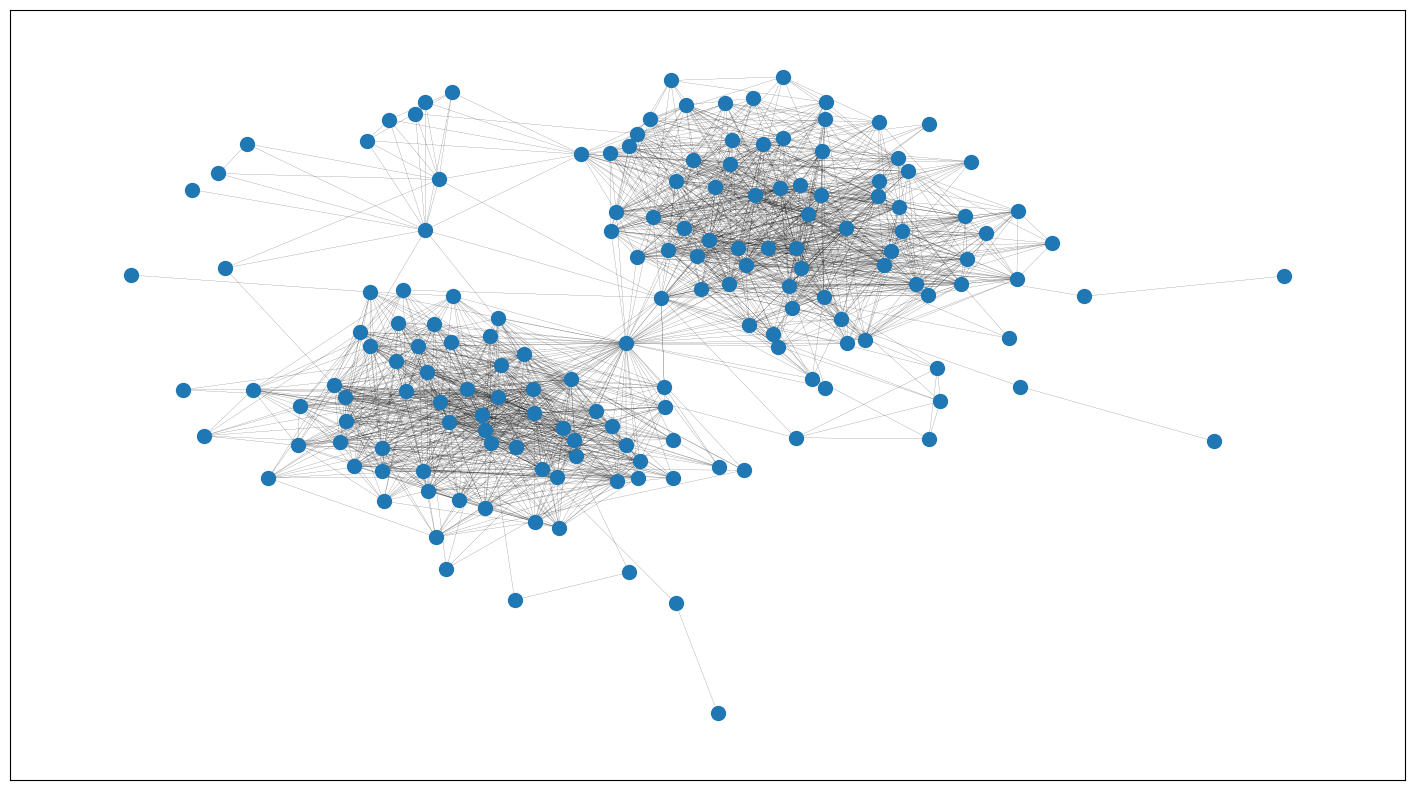

In [6]:
plt.figure(figsize=(18, 10))
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=layout, with_labels=False, node_size=100, width=0.1)

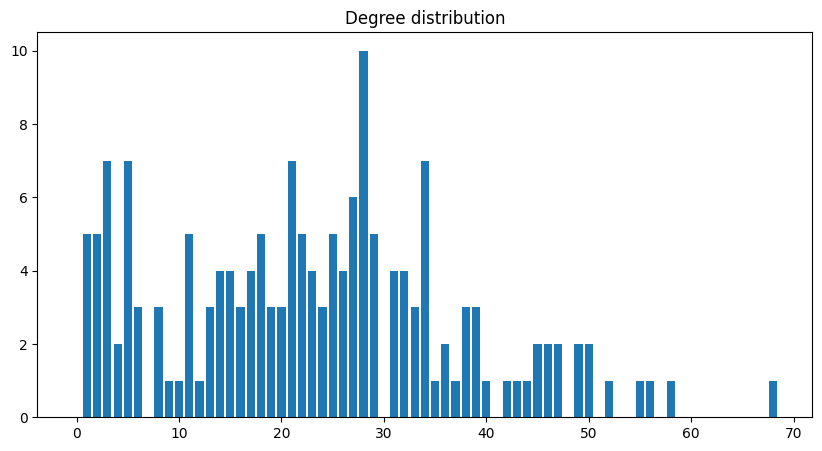

In [7]:
degrees = nx.degree_histogram(G)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(degrees)) , degrees)
plt.title('Degree distribution')
plt.show()

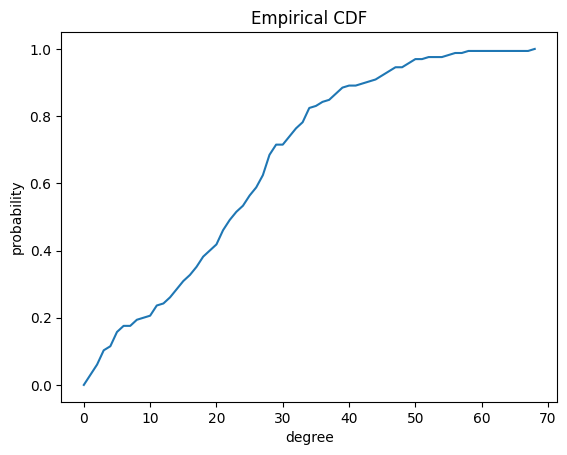

In [8]:
def empirical_cdf(g: nx.Graph):
    hist = nx.degree_histogram(g)
    return np.cumsum(hist) / sum(hist)

ecdf = empirical_cdf(G)
plt.plot(ecdf)
plt.xlabel('degree')
plt.ylabel('probability')
plt.title('Empirical CDF')
plt.show()

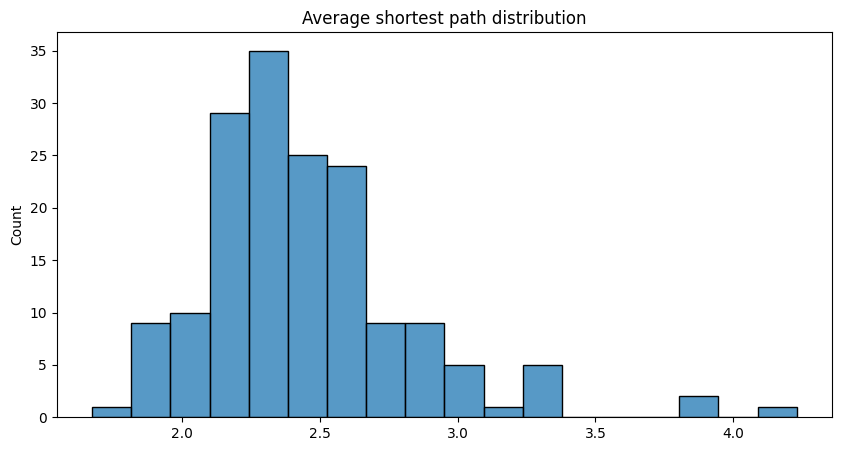

In [9]:
all_shortest_path = list(nx.shortest_path_length(G))
shortest_paths = []
for node, paths in all_shortest_path:
    shortest_paths.append(np.mean(list(paths.values())))
    
plt.figure(figsize=(10, 5))
sns.histplot(shortest_paths)
plt.title('Average shortest path distribution')
plt.show()

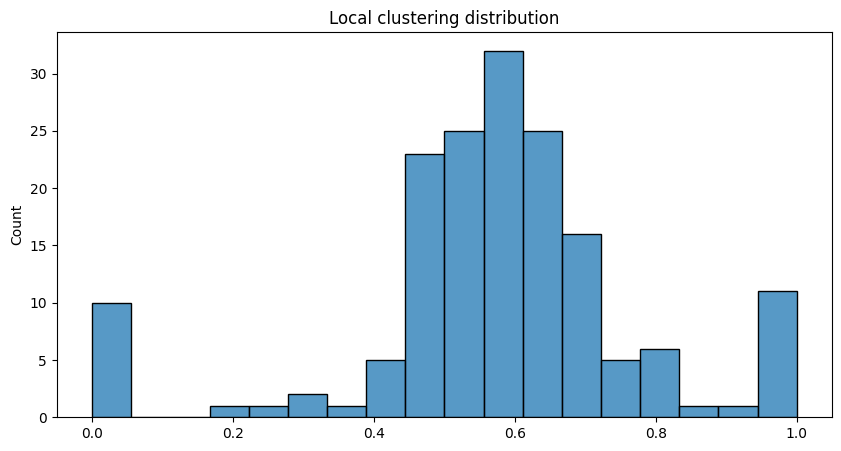

In [10]:
local_clustering = list(nx.clustering(G).values())

plt.figure(figsize=(10, 5))
sns.histplot(local_clustering)
plt.title('Local clustering distribution')
plt.show()

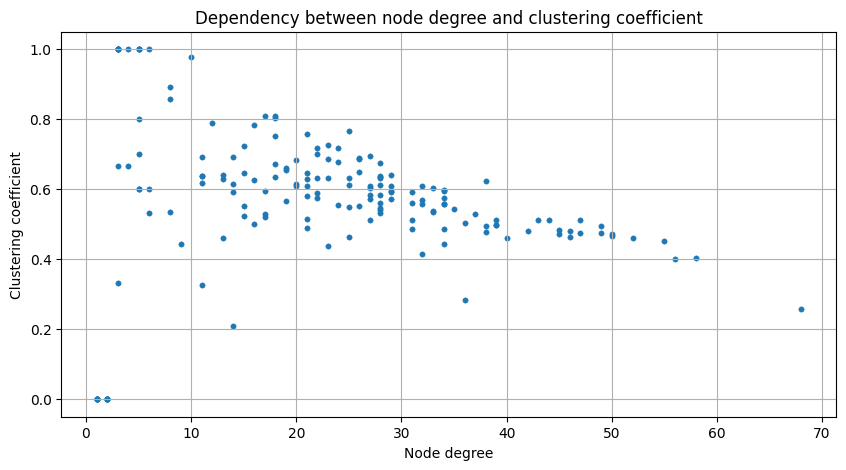

In [11]:
degree = np.array(list(dict(nx.degree(G)).values()))
clustering = np.array(list(nx.clustering(G).values()))

plt.figure(figsize=(10, 5))
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.title('Dependency between node degree and clustering coefficient')
plt.grid()
plt.show()

## Structural Analysis

- Degree/Closeness/Betweenness/Katz centralities.
- Page-Rank. Correlation comparison of centralities and prestige. Comparison of top nodes.
- Node structural equivalence/similarity.
- Assortative Mixing according to node attributes.
- The closest random graph model similar to your social network (compare models from lectures, such as ER, BA, WS)
- Top nodes interpretation (not just surnames, but their social roles).

### Centralities

In [12]:
def centralities(G: nx.Graph):
    """
    Calculate degree, closeness, betweenness centralities of the graph
    """
    A = nx.to_numpy_array(G)
    alpha = 1 / np.ceil(max(np.linalg.eigvals(A)))
    
    return {
        'degree': np.array(list(nx.degree_centrality(G).values())),
        'closeness': np.array(list(nx.closeness_centrality(G).values())),
        'betweenness': np.array(list(nx.betweenness_centrality(G).values())),
        'katz': np.array(list(nx.katz_centrality(G, alpha=alpha, max_iter=10_000).values()))
    }

def top10_centralities(G: nx.Graph):
    """
    Create table of top 10 nodes by degree, closeness, betweenness centralities
    """
    A = nx.to_numpy_array(G)
    alpha = 1 / np.ceil(max(np.linalg.eigvals(A)))
    
    cases = [['degree', nx.degree_centrality(G)], 
             ['closeness', nx.closeness_centrality(G)], 
             ['betweenness', nx.betweenness_centrality(G)],
             ['katz', nx.katz_centrality(G, alpha=alpha, max_iter=10_000)]]
    dfs = {}
    for title, centrality in cases:
        top = sorted(centrality.items(), key=lambda i: i[1], reverse=True)[:10]
        user_label = [i for i, val in top]
        user_name = [G.nodes[i]['name'] for i, val in top]
        centr_value = [val for i, val in top]
        dfs[title] = pd.DataFrame({'name': user_name, 
                                   'label': user_label, 
                                   'centrality': centr_value})
    return dfs

Degree centrality


name  centrality
0            Данил Самылов    0.414634
1       Алексей Колесников    0.353659
2           Egor Igorevich    0.341463
3        Николай Герасимов    0.335366
4  Екатерина Красильникова    0.317073
5              Егор Иванов    0.304878
6             Роберт Атаев    0.304878
7         Владислав Иринин    0.298780
8          Илья Великоднев    0.298780
9           Рашид Кильдаев    0.286585

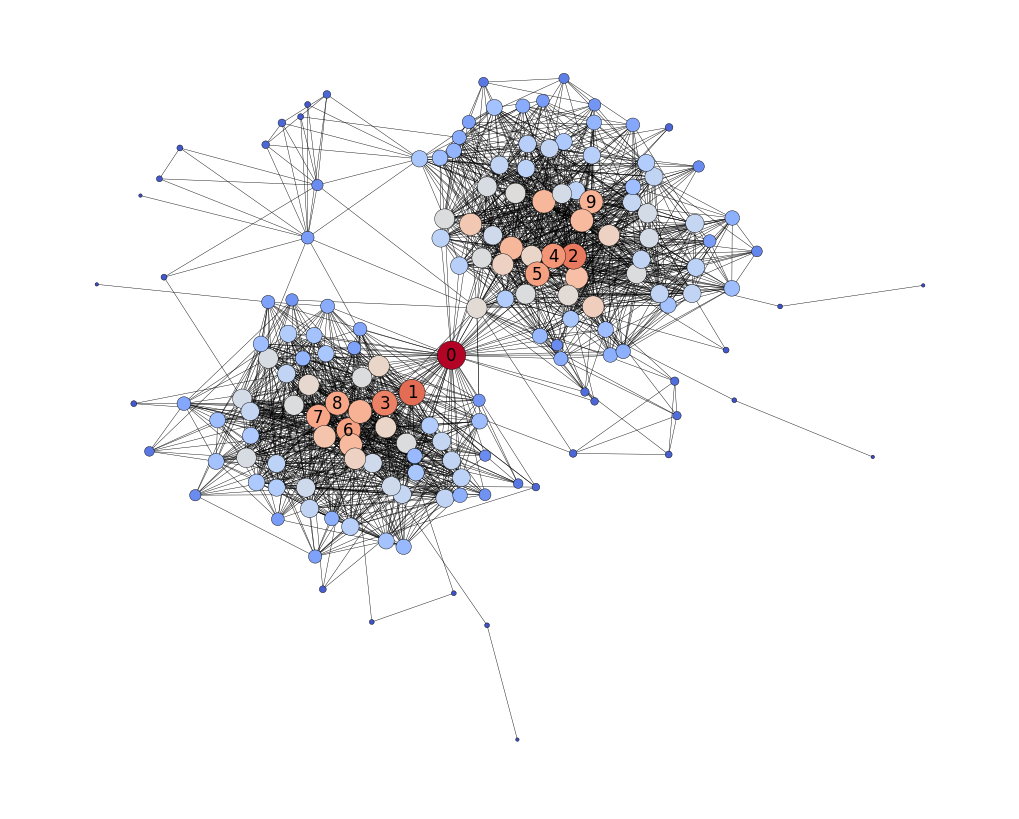

Closeness centrality


name  centrality
0            Данил Самылов    0.594203
1       Алексей Колесников    0.543046
2          Владимир Храмов    0.535948
3           Egor Igorevich    0.530744
4  Екатерина Красильникова    0.518987
5              Егор Иванов    0.518987
6           Андрей Новиков    0.514107
7             Дарья Ценева    0.512500
8              Владимир Ан    0.512500
9        Николай Герасимов    0.509317

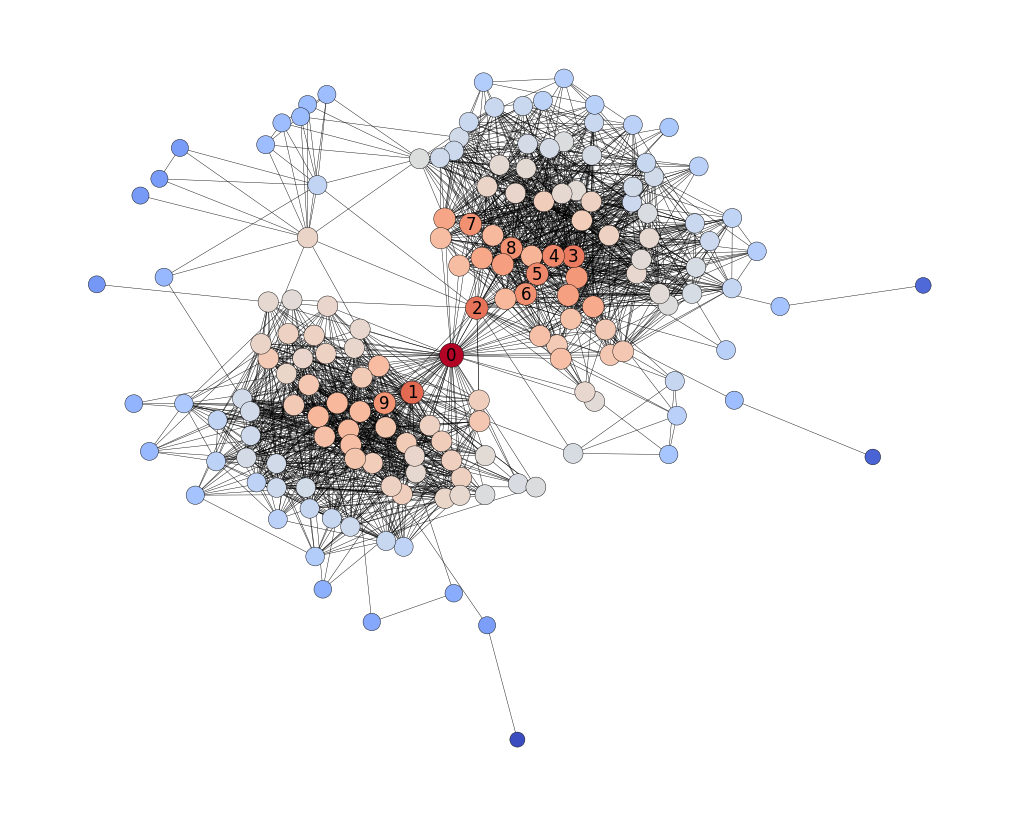

Betweenness centrality


name  centrality
0       Данил Самылов    0.325075
1     Владимир Храмов    0.103065
2  Алексей Колесников    0.081045
3    Вячеслав Поляков    0.064981
4      Андрей Новиков    0.062571
5      Egor Igorevich    0.059710
6         Антон Орлов    0.039968
7    Евгения Миронова    0.036292
8   Николай Герасимов    0.030546
9      Наташа Данилюк    0.029480

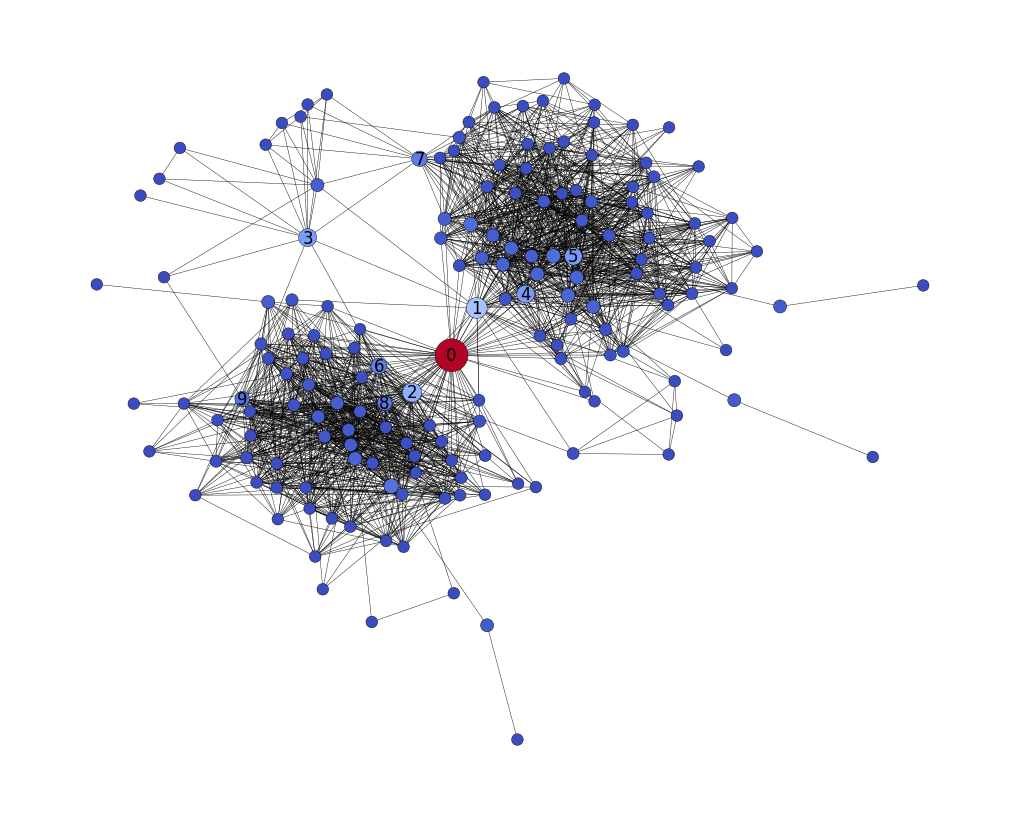

Katz centrality


name  centrality
0            Данил Самылов    0.188467
1       Алексей Колесников    0.157350
2        Николай Герасимов    0.154719
3             Роберт Атаев    0.141442
4         Владислав Иринин    0.141254
5           Egor Igorevich    0.141094
6  Екатерина Красильникова    0.140306
7          Илья Великоднев    0.139078
8          Александр Молла    0.138305
9              Егор Иванов    0.136525

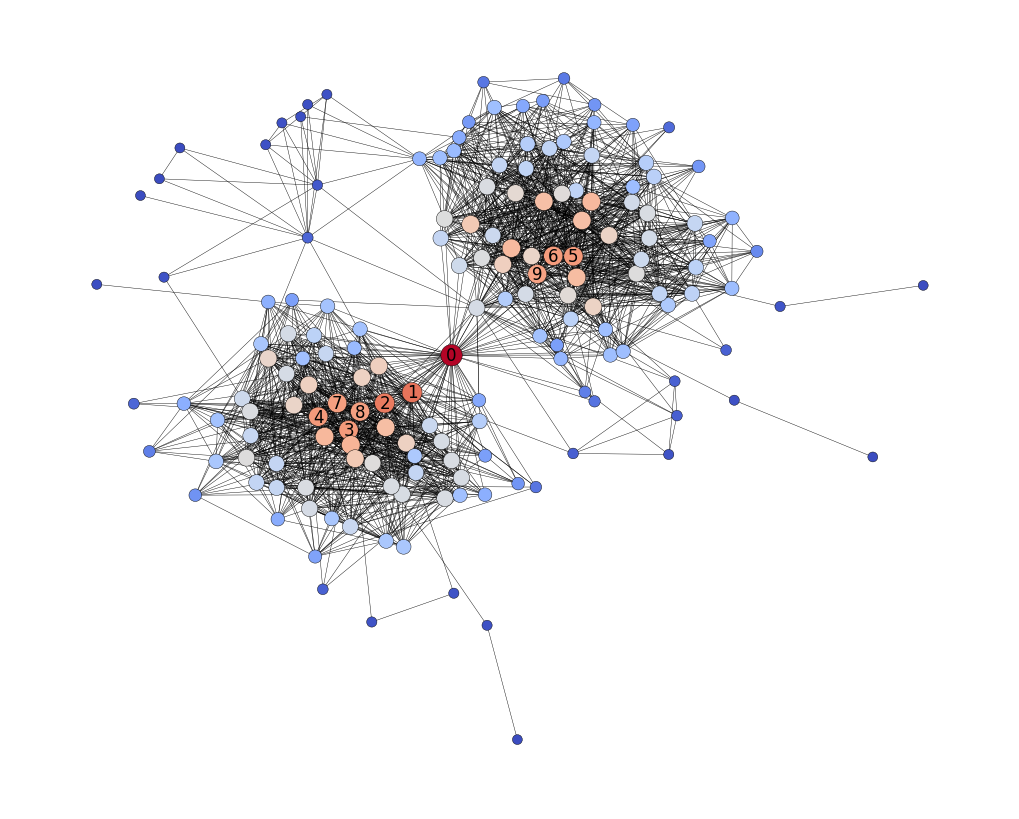

In [13]:
c = centralities(G)
top_dfs = top10_centralities(G)
pos = nx.kamada_kawai_layout(G)

cases = [['degree', 1000, 0, 'Degree centrality'], 
         ['closeness', 500, 0, 'Closeness centrality'], 
         ['betweenness', 1500, 70, 'Betweenness centrality'],
         ['katz', 1000, 50, 'Katz centrality']]

for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key][['name', 'centrality']])
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            pos,
            width=0.3,
            linewidths=0.3,
            edgecolors='black',
            cmap=plt.cm.coolwarm,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    
    labels = {label:place for place, label in top_dfs[c_key]['label'].to_dict().items()}
    nx.draw_networkx_labels(G, pos, labels)
    
    plt.show()

### Page-Rank. Correlation comparison of centralities and prestige. Comparison of top nodes.

In [15]:
pr = np.array(list(nx.pagerank(G, alpha=0.9).values()))

pr_tope = pd.DataFrame([(node, G.nodes[node]['name'], rank) for node, rank in enumerate(pr)],
                       columns=['node', 'name', 'page_rank']).\
                sort_values(by='page_rank', ascending=False).\
                reset_index(drop=True)

pr_tope.head(10)

node                     name  page_rank
0    77            Данил Самылов   0.016268
1    20           Egor Igorevich   0.014373
2    84       Алексей Колесников   0.014084
3    74        Николай Герасимов   0.013066
4    48  Екатерина Красильникова   0.012411
5    56              Егор Иванов   0.012002
6    88             Роберт Атаев   0.011916
7   101          Илья Великоднев   0.011873
8    82         Владислав Иринин   0.011788
9    16           Рашид Кильдаев   0.011334

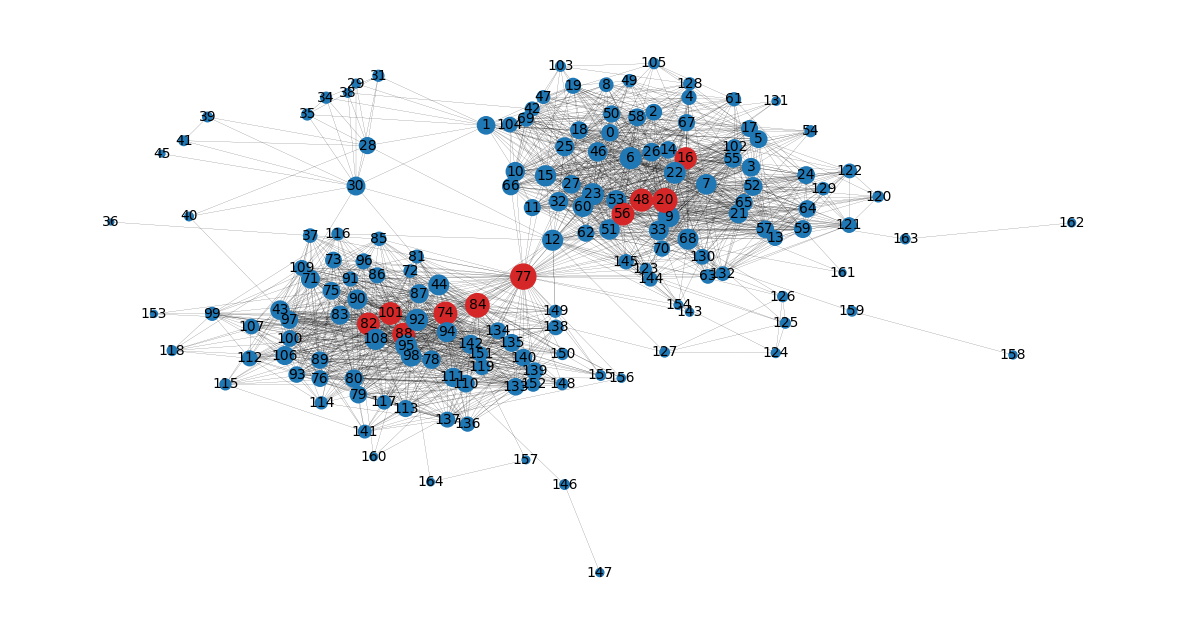

In [16]:
best_nodes_by_pr = list(pr_tope['node'].head(10))
colors = np.array(['tab:blue'] * G.number_of_nodes())
colors[best_nodes_by_pr] = 'tab:red'

plt.figure(figsize=(15, 8))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos, 
                 node_size=(pr * 2e4),
                 width=0.1,
                 font_size=10,
                 node_color=colors
                )
plt.axis('off')
plt.show()

In [17]:
centralities_df = pd.DataFrame({
    'degree': c['degree'],
    'closeness': c['closeness'],
    'betweenness': c['betweenness'],
    'page_rank': pr
})

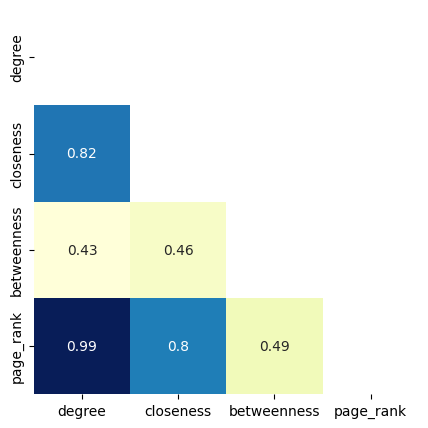

In [18]:
plt.figure(figsize=(6, 5))
cent_corr = centralities_df.corr()
mask = np.triu(np.ones_like(cent_corr, dtype=bool))
sns.heatmap(cent_corr, cmap="YlGnBu", annot=True, mask=mask, square=True, cbar=False)
plt.show()

<Figure size 1800x1000 with 0 Axes>

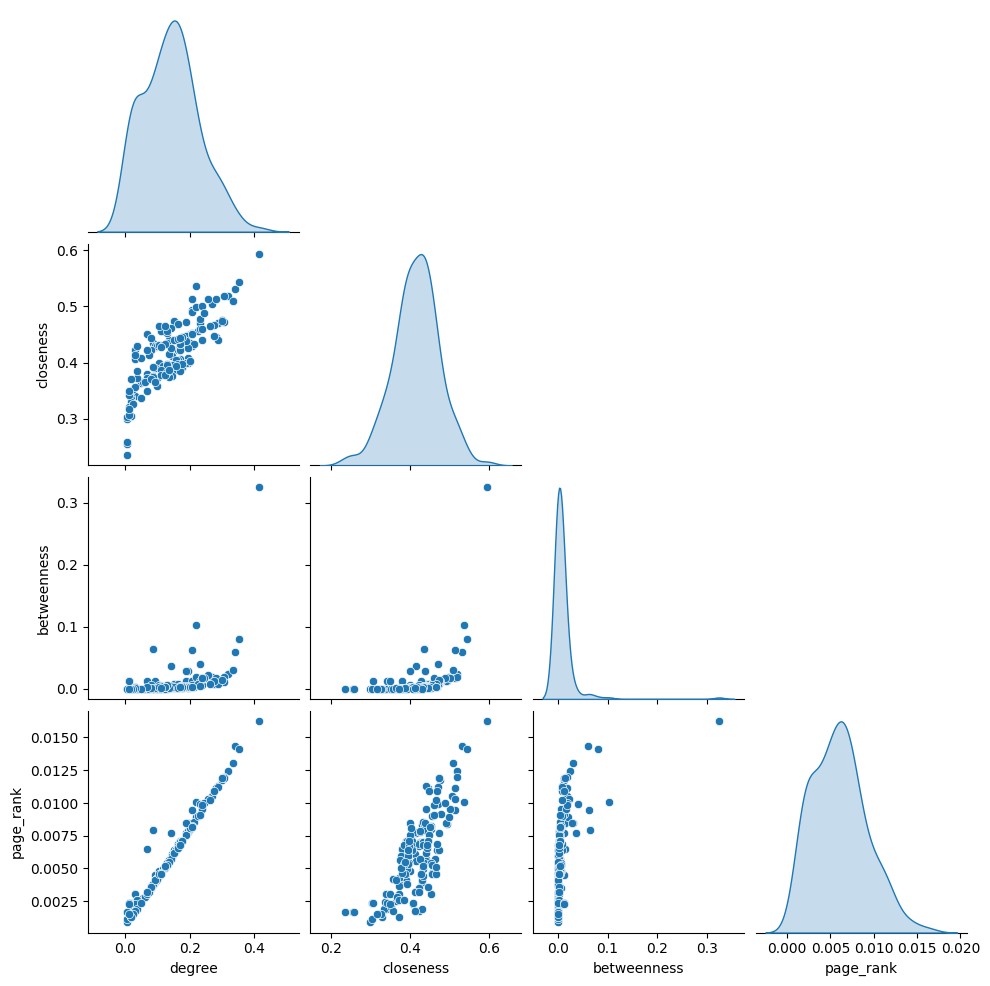

In [19]:
plt.figure(figsize=(18, 10))
sns.pairplot(centralities_df, corner=True, diag_kind='kde')
plt.show()

### Node structural equivalence/similarity

In [20]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix

In [21]:
def sim_values(A, i, j):
    A_i, A_j = A[i, :], A[:, j]
    i_diff, j_diff = A_i - A_i.mean(), A_j - A_j.mean()
    r = np.sum(i_diff * j_diff) / (np.sqrt(np.sum(i_diff**2)) * np.sqrt(np.sum(j_diff**2)))
    j = sum(np.logical_and(A_i, A_j)) / sum(np.logical_or(A_i, A_j))
    cos = A_i.T @ A_j / (np.linalg.norm(A_i) * np.linalg.norm(A_j))
    
    return r, j, cos

def compute_sim(G):
    A = nx.to_numpy_array(G)
    cos_sim = np.zeros(A.shape)
    pearson_sim = np.zeros(A.shape)
    jaccard_sim = np.zeros(A.shape)
    for i in range(len(G)):
        for j in range(i, (len(G))):
            pval, jval, cval = sim_values(A, i, j)
            pearson_sim[i, j] = pval
            pearson_sim[j, i] = pval
            jaccard_sim[i, j] = jval
            jaccard_sim[j, i] = jval
            cos_sim[i, j] = cval
            cos_sim[j, i] = cval
    return pearson_sim, jaccard_sim, cos_sim

def cm_order(G):
    A = nx.to_numpy_array(G)
    return reverse_cuthill_mckee(csr_matrix(A), symmetric_mode=True)

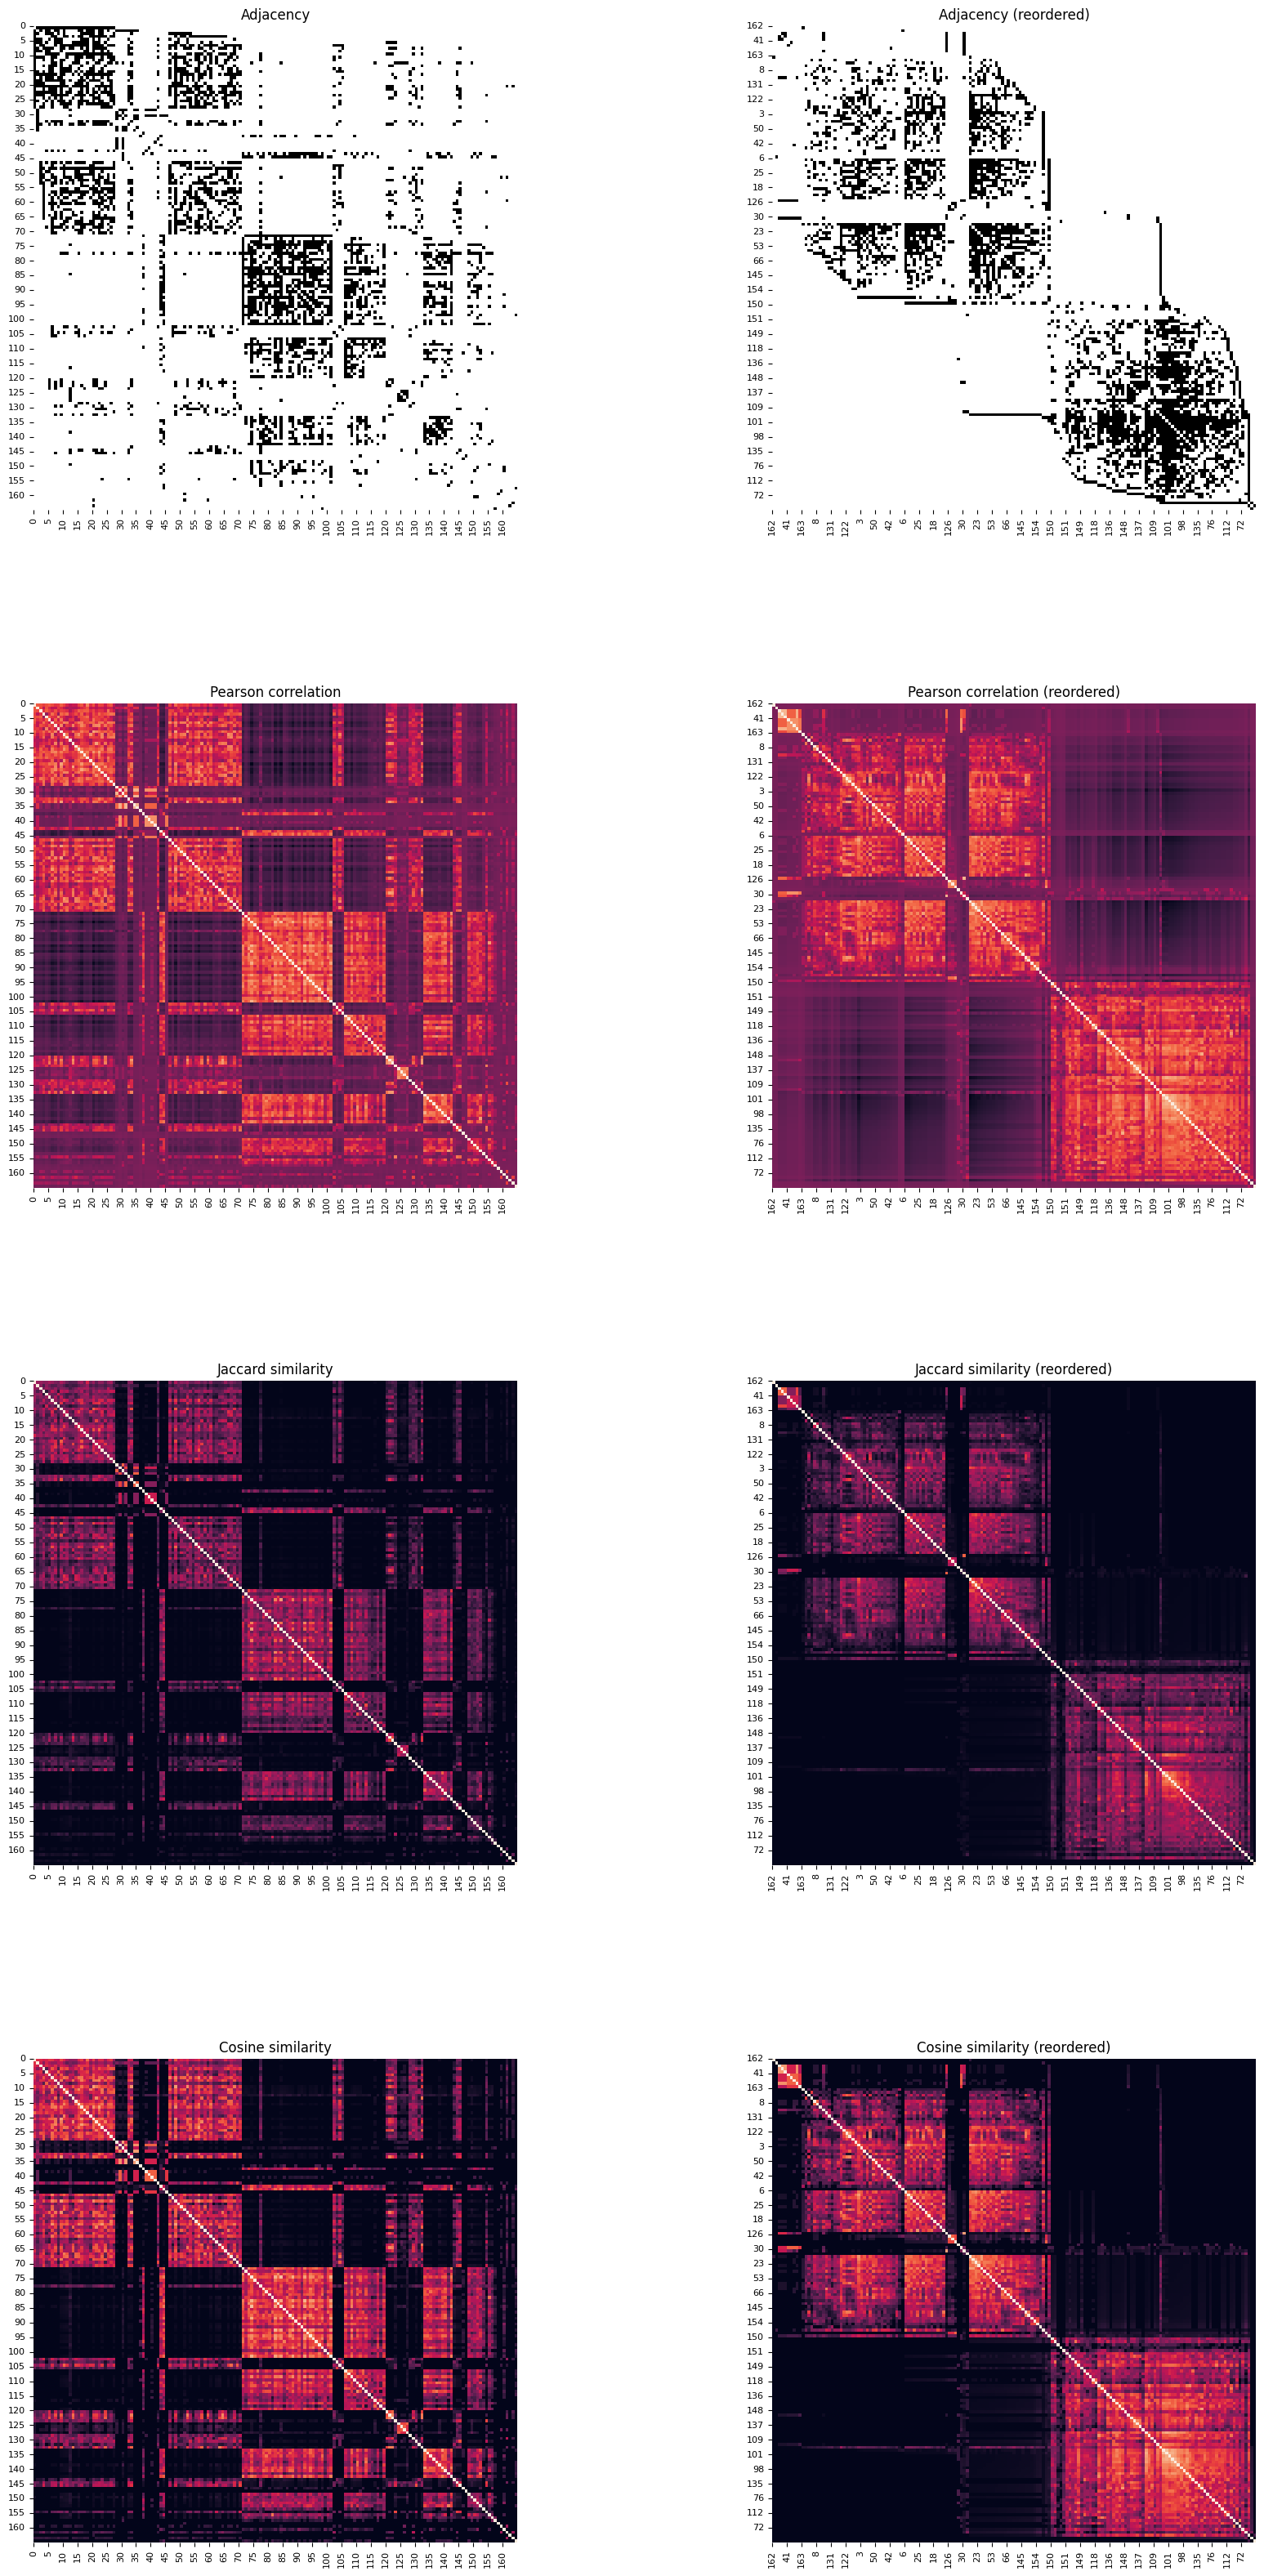

In [22]:
pearson_sim, jaccard_sim, cos_sim = compute_sim(G)
order = cm_order(G)
A = nx.to_numpy_array(G)
num_nodes = G.number_of_nodes()

new_labels = np.array([node for node in G.nodes()])

fig = plt.figure(figsize=(20, 20*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(num_nodes)],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, pearson_sim, None, 'Pearson correlation', range(num_nodes)], 
         [4, pearson_sim, None, 'Pearson correlation (reordered)', order], 
         [5, jaccard_sim, None, 'Jaccard similarity', range(num_nodes)], 
         [6, jaccard_sim, None, 'Jaccard similarity (reordered)', order], 
         [7, cos_sim, None, 'Cosine similarity', range(num_nodes)], 
         [8, cos_sim, None, 'Cosine similarity (reordered)', order]
]

labels = np.arange(num_nodes)

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True,
    )
    plt.xticks(ticks=range(num_nodes)[::5], labels=new_labels[o][::5], rotation=90, fontsize=8)
    plt.yticks(ticks=range(num_nodes)[::5], labels=new_labels[o][::5], rotation=0, fontsize=8)
    plt.title(t)

### Assortative Mixing

In [23]:
# Заполнение вручную города для некоторых пользователей
with open('cities_for_problem_users.json', 'r') as fp:
    cities_for_problem_users = json.load(fp)
    
for node in G.nodes():
    cur_id = str(G.nodes[node]['id'])
    if cur_id in cities_for_problem_users.keys():
        G.nodes[node]['city'] = cities_for_problem_users[cur_id]

In [24]:
def conferences_mixing_matrix(G, mapping, attr_name):
    arr = np.zeros((len(mapping), len(mapping)))
    
    for u, v in G.edges():
        u_id = mapping[G.nodes[u][attr_name]]
        v_id = mapping[G.nodes[v][attr_name]]

        arr[u_id, v_id] += 1
        arr[v_id, u_id] += 1

    arr /= (2 * len(G.edges()))
    
    return arr

def plot_assortative_mixing(mixing, mapping, attr_name, rotate_xticks):
    fig = plt.figure(figsize=(6, 6))
    hmap = sns.heatmap(
        mixing,
        cbar=True,
        square=True,
        cmap=sns.color_palette("viridis", as_cmap=True)
    )
    hmap.set_xticklabels([m for m in mapping], rotation=90 if rotate_xticks else 0)
    hmap.set_yticklabels([m for m in mapping], rotation=0)
    plt.title(f'Assortative mixing for {attr_name} attribute')
    plt.show()
    
def assortative_mixing(G, attr_name, rotate_xticks=False):
    conf_values = np.random.permutation(
        np.unique([G.nodes[n][attr_name] for n in G.nodes])
    )
    mapping = {val: i for i, val in enumerate(conf_values)}
    mixing = conferences_mixing_matrix(G, mapping, attr_name)
    plot_assortative_mixing(mixing, mapping, attr_name, rotate_xticks)

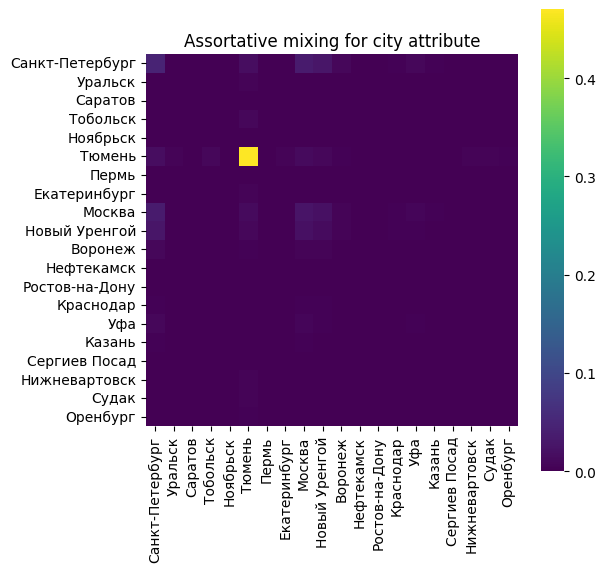

In [25]:
assortative_mixing(G, 'city', rotate_xticks=True)

In [26]:
for node in G.nodes():
    if G.nodes[node]['sex'] == 2:
        G.nodes[node]['sex'] = 'Male'
    else:
        G.nodes[node]['sex'] = 'Female'

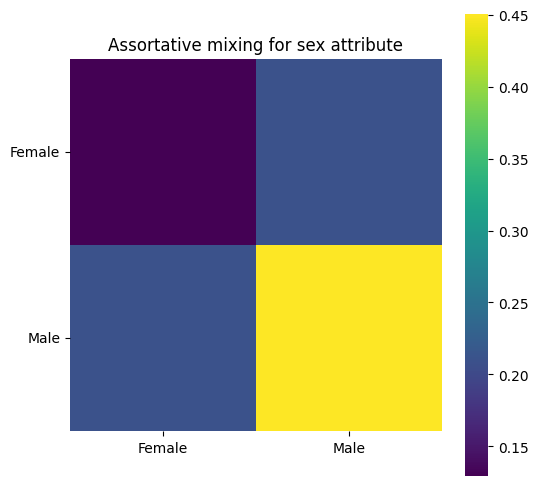

In [27]:
assortative_mixing(G, 'sex')

### The closest random graph

In [37]:
def empirical_cdf(g):
    hist = nx.degree_histogram(g)
    return np.cumsum(hist) / sum(hist)

def calc_kstest(true_g, rand_g):
    p_seq = empirical_cdf(true_g)
    cdf = empirical_cdf(rand_g)
    if len(cdf) < len(p_seq):
        cdf = np.append(cdf, np.repeat(1, len(p_seq) - len(cdf)))
    
    stat, pvalue = st.kstest(cdf, p_seq)
    return stat

def func_error(func, true_g, rand_g):
    true, rand = func(true_g), func(rand_g)
    return abs(true - rand) / true

def compare_graphs(true_g, rand_g):
    radius = func_error(nx.radius, true_g, rand_g)
    diameter = func_error(nx.diameter, true_g, rand_g)
    average_clustering = func_error(nx.average_clustering, true_g, rand_g)
    average_path_length = func_error(nx.average_shortest_path_length, true_g, rand_g)
    ks_dist = calc_kstest(true_g, rand_g)
    
    x = np.array([ks_dist, radius, diameter, average_path_length, average_clustering],
                 dtype='float')
    
    print(f"score: {np.sum(x) / len(x):.3f}")
    print('Relative errors:')
    print(f"KS dist: {x[0]:.2f}, radius: {x[1]:.2f}, diameter: {x[2]:.2f}, "
          f"average_path_length: {x[3]:.2f}, average_clustering: {x[4]:.2f}")

#### Erdős-Rényi model

In [32]:
erdos_scores = []
number_nodes = G.number_of_nodes()
for p in tqdm(np.linspace(0.03, 0.6, 58)):
    g = nx.erdos_renyi_graph(number_nodes, p, seed=42)
    score = calc_kstest(G, g)
    erdos_scores.append((p, score))

  0%|          | 0/58 [00:00<?, ?it/s]

In [33]:
pd.DataFrame(erdos_scores, columns=['p', 'score'])\
    .sort_values(by='score').head()

p     score
17  0.20  0.333333
18  0.21  0.347826
16  0.19  0.347826
19  0.22  0.376812
15  0.18  0.405797

In [38]:
g = nx.erdos_renyi_graph(number_nodes, 0.20, seed=42)
compare_graphs(G, g)

score: 0.450
Relative errors:
KS dist: 0.33, radius: 0.50, diameter: 0.50, average_path_length: 0.27, average_clustering: 0.65


In [39]:
main_stats(g)

Graph type:  <class 'networkx.classes.graph.Graph'>
Number of nodes:  165
Number of edges:  2726
Radius:  2
Diameter  3
Average shortest path length:  1.799630450849963
Average clustering coefficient:  0.2017292952686008


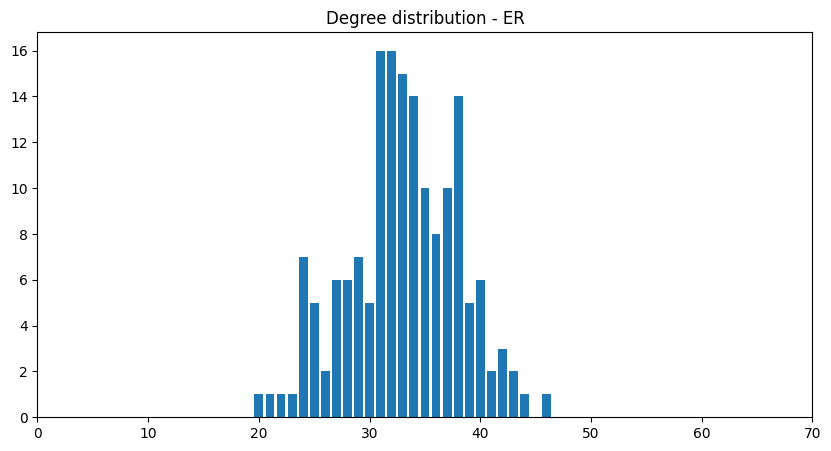

In [40]:
degrees = nx.degree_histogram(g)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(degrees)) , degrees)
plt.xlim(0, 70)
plt.title('Degree distribution - ER')
plt.show()

#### Barabási–Albert model

In [43]:
def grid_barabasi_albert(GG):
    scores = []
    number_nodes = GG.number_of_nodes()

    start_graphs = [('star', nx.star_graph),
                   ('complete', nx.complete_graph)]

    for name_start, type_start in start_graphs:
        for m in tqdm(list(range(2, 21))):
            g = nx.barabasi_albert_graph(number_nodes, m,
                                        seed=42,
                                        initial_graph=type_start(m))
            score = calc_kstest(GG, g)
            scores.append((name_start, m, score))
    
    scores.sort(key=lambda x: x[2])

    return scores

In [44]:
scores = grid_barabasi_albert(G)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [45]:
pd.DataFrame(scores, columns=['initial_graph', 'm', 'score'])\
    .sort_values(by='score').head()

initial_graph   m     score
0          star  11  0.144928
1      complete  11  0.144928
2          star  12  0.149891
3      complete  12  0.152174
4      complete  14  0.154182

In [46]:
m = 11
g = nx.barabasi_albert_graph(number_nodes, m,
                             seed=42,
                             initial_graph=nx.star_graph(m))

In [47]:
compare_graphs(G, g)

score: 0.397
Relative errors:
KS dist: 0.14, radius: 0.50, diameter: 0.50, average_path_length: 0.20, average_clustering: 0.64


In [48]:
main_stats(g)

Graph type:  <class 'networkx.classes.graph.Graph'>
Number of nodes:  165
Number of edges:  1694
Radius:  2
Diameter  3
Average shortest path length: 1.96
Average clustering coefficient: 0.21


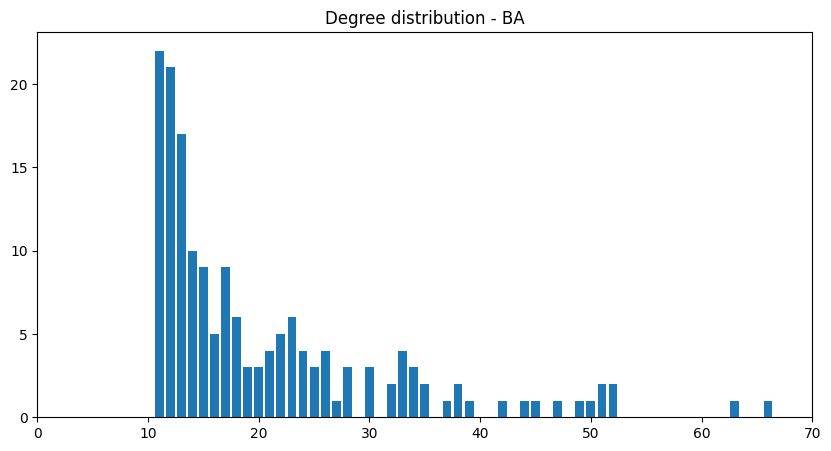

In [49]:
degrees = nx.degree_histogram(g)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(degrees)) , degrees)
plt.xlim(0, 70)
plt.title('Degree distribution - BA')
plt.show()

#### Watts–Strogatz small-world model

In [50]:
scores = []
number_nodes = G.number_of_nodes()

for k in tqdm(range(10, 50)):
    for p in np.linspace(0.01, 0.99, 99):
        g = nx.watts_strogatz_graph(number_nodes, k, p, seed=42)
        score = calc_kstest(G, g)
        scores.append((k, p, score))

  0%|          | 0/40 [00:00<?, ?it/s]

In [51]:
pd.DataFrame(scores, columns=['k', 'p', 'score'])\
    .sort_values(by='score').head()

k     p     score
2169  31  0.91  0.333333
2070  30  0.91  0.333333
2371  33  0.95  0.347826
2252  32  0.75  0.347826
2240  32  0.63  0.347826

In [52]:
g = nx.watts_strogatz_graph(number_nodes, 31, 0.91, seed=42)

In [53]:
compare_graphs(G, g)

score: 0.456
Relative errors:
KS dist: 0.33, radius: 0.50, diameter: 0.50, average_path_length: 0.26, average_clustering: 0.69


In [54]:
main_stats(g)

Graph type:  <class 'networkx.classes.graph.Graph'>
Number of nodes:  165
Number of edges:  2475
Radius:  2
Diameter  3
Average shortest path length: 1.82
Average clustering coefficient: 0.18


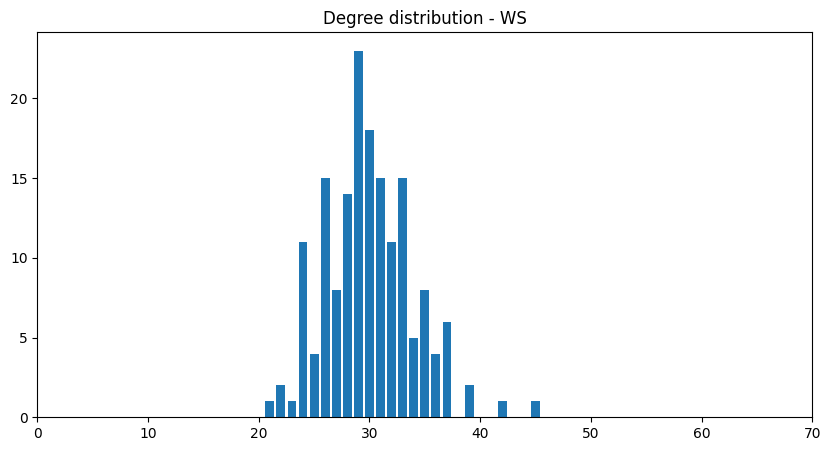

In [55]:
degrees = nx.degree_histogram(g)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(degrees)) , degrees)
plt.xlim(0, 70)
plt.title('Degree distribution - WS')
plt.show()

#### custom random graph

In [56]:
def girvan_newman(G, n):
    labels = np.zeros((n, len(G)))
    _G = G.copy()
    for division in range(n):
        remove_bridges(_G)
        for i, cc in enumerate(nx.connected_components(_G)):
            labels[division, list(cc)] = i
    return labels

def remove_bridges(G):
    num_comp = len(list(nx.connected_components(G)))
    while len(list(nx.connected_components(G))) == num_comp:
        b = nx.edge_betweenness_centrality(G)
        edge = max(b, key=b.get)
        G.remove_edge(*edge)

In [57]:
labels = girvan_newman(G, 8)
label = labels[9-2]
nodes = np.array(G.nodes())
commun = [list(nodes[label == i]) for i in range(6)]

for com in commun:
    print(len(com))

74
11
1
67
4
2


In [88]:
subG_1 = G.subgraph(commun[0])
subG_2 = G.subgraph(commun[3])

subG_1.number_of_nodes(), subG_2.number_of_nodes()

(74, 67)

In [89]:
scores_1 = grid_barabasi_albert(subG_1)
scores_2 = grid_barabasi_albert(subG_2)

print('graph_1')
print(*scores_1[:2], sep='\n')
print('graph_2')
print(*scores_2[:2], sep='\n')

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

graph_1
('star', 18, 0.13779904306220095)
('star', 20, 0.1471861471861472)
graph_2
('star', 18, 0.125)
('star', 15, 0.14285714285714285)


In [90]:
g_1 = nx.barabasi_albert_graph(subG_1.number_of_nodes(),
                               18,
                               seed=42,
                               initial_graph=nx.star_graph(18))

g_2 = nx.barabasi_albert_graph(subG_2.number_of_nodes(),
                               18,
                               seed=42,
                               initial_graph=nx.star_graph(18))

In [91]:
n_1 = g_1.number_of_nodes()
n_2 = g_2.number_of_nodes()

mapping = dict(zip(g_2.nodes(), range(n_1, n_1 + n_2)))

g_2 = nx.relabel_nodes(g_2, mapping)

In [92]:
g = nx.compose(g_1, g_2)

In [93]:
"""
Выберем из первого подграфа вершину с наибольшей степени
и сделаем так, чтобы количество вершин, с которыми она соединена,
была равным и в сумме равнялось наивысшей степени вершины из исходного графа
"""

top_node_G = sorted(list(G.degree()), key=lambda x: x[1], reverse=True)[0]
top_node_g_1 = sorted(list(g_1.degree()), key=lambda x: x[1], reverse=True)[0]
u = top_node_g_1[0]

edges_to_every_cluster = top_node_G[1] // 2
edges = list(g.edges(u))


for idx_edge in np.random.choice(list(range(len(g.edges(u)))),
                                 top_node_g_1[1] - edges_to_every_cluster,
                                 replace=False):
    g.remove_edge(*edges[idx_edge])
    
for v in np.random.choice(g_2.nodes(), edges_to_every_cluster, replace=False):
    g.add_edge(u, v)

In [94]:
def grid_barabasi_albert_custom_initial(GG, initial):
    scores = []
    number_nodes = GG.number_of_nodes()

    for m in range(2, 21):
        g = nx.barabasi_albert_graph(number_nodes, m,
                                    seed=42,
                                    initial_graph=initial)
        score = calc_kstest(GG, g)
        scores.append((m, score))

    scores.sort(key=lambda x: x[1])
    
    return scores

In [95]:
scores = grid_barabasi_albert_custom_initial(G, g)
print(*scores[:5], sep='\n')

(5, 0.08382295338817078)
(7, 0.08382295338817078)
(3, 0.08715505261068096)
(4, 0.08715505261068096)
(6, 0.08715505261068096)


In [96]:
final_g = nx.barabasi_albert_graph(G.number_of_nodes(),
                                   5,
                                   seed=42,
                                   initial_graph=g)

In [97]:
compare_graphs(G, final_g)

score: 0.198
Relative errors:
KS dist: 0.08, radius: 0.25, diameter: 0.33, average_path_length: 0.09, average_clustering: 0.23


In [98]:
main_stats(final_g)

Graph type:  <class 'networkx.classes.graph.Graph'>
Number of nodes:  165
Number of edges:  2022
Radius:  3
Diameter  4
Average shortest path length: 2.23
Average clustering coefficient: 0.44


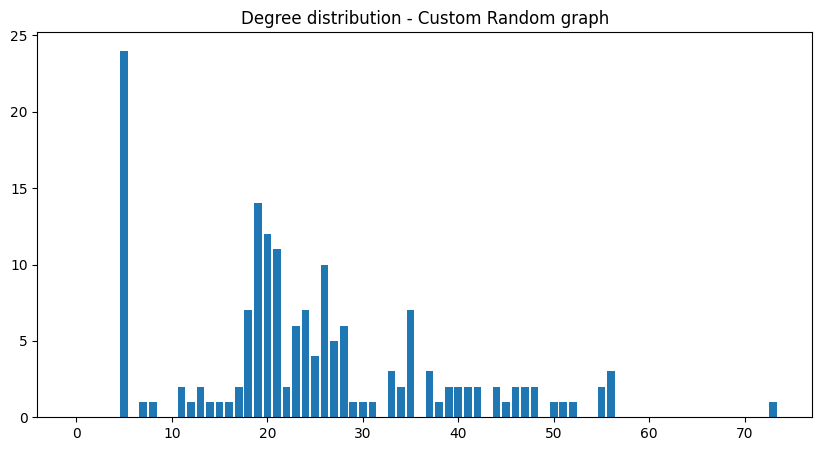

In [99]:
degrees = nx.degree_histogram(final_g)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(degrees)) , degrees)
plt.title('Degree distribution - Custom Random graph')
plt.show()

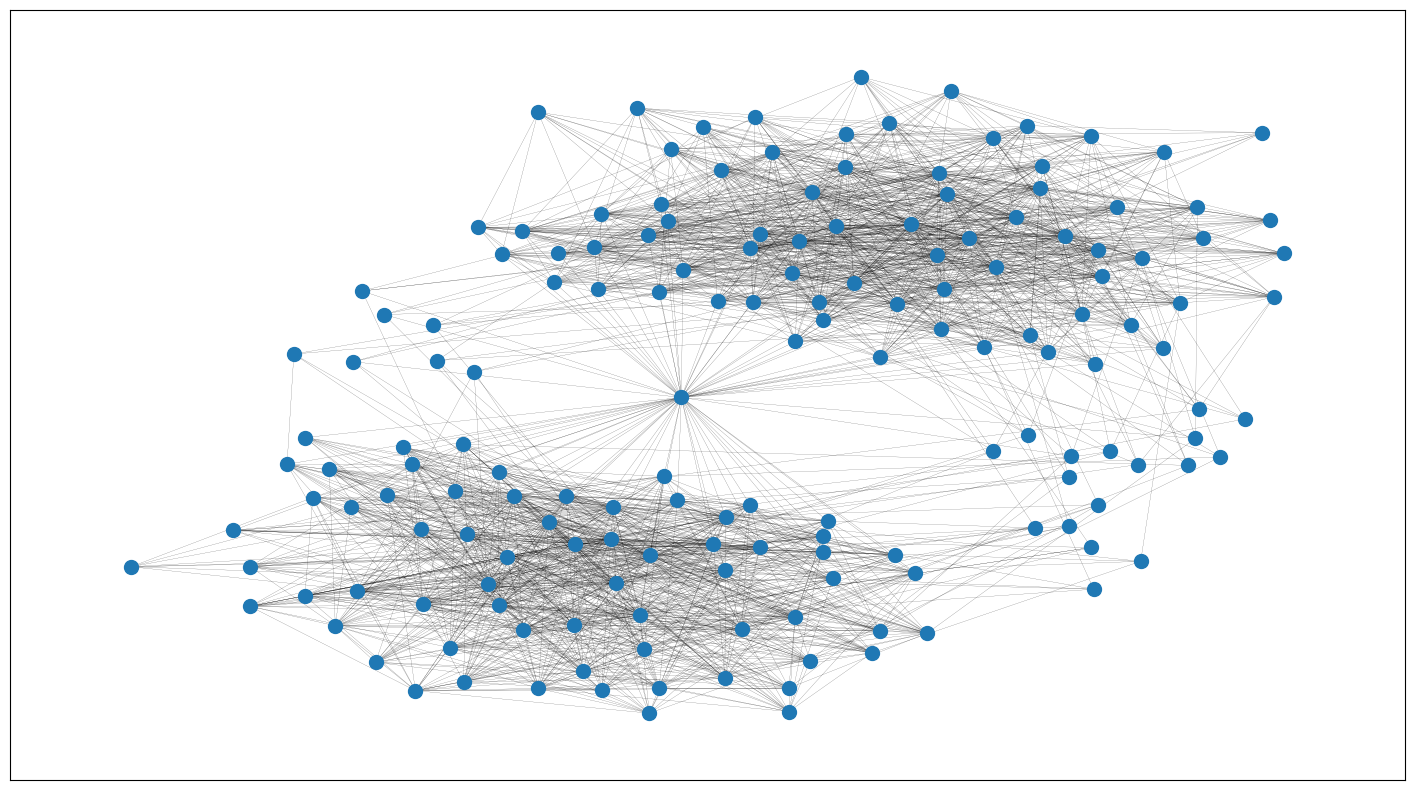

In [100]:
plt.figure(figsize=(18, 10))
layout = nx.kamada_kawai_layout(final_g)
nx.draw_networkx(final_g, pos=layout, with_labels=False, node_size=100, width=0.1)

## Community Detection

- Modularity for quality criterion
- Community detection algorithms
    - Agglomerative Clustering
    - Girvan-Newman algorithm
    - k-cores decomposition
- Clique search
- Interpretations over image with community detection

### Modularity

In [101]:
import networkx.algorithms.community as nx_comm


def modularity_grid(G, labels, x_grid, x_name):
    assert len(labels) == len(x_grid)
    
    mod_val = []
    nodes = np.arange(G.number_of_nodes())
    for label in labels:
        commun = [list(nodes[label == i]) for i in range(int(max(label)) + 1)]
        mod = nx_comm.modularity(G, commun)
        mod_val.append(mod)
    mod_val = np.array(mod_val)
    
    plt.figure(figsize=(10, 4))
    plt.plot(x_grid, mod_val)
    best_n = x_grid[np.argmax(mod_val)]
    label = 'max modularity {:.2f}'.format(best_n)
    plt.plot(
        [best_n, best_n], [min(mod_val), max(mod_val)], 
        linestyle='--', c='tab:red', 
        label=label
    )
    plt.ylabel('Modularity score')
    plt.xlabel(x_name)
    plt.legend(loc='upper left')
    plt.xticks(x_grid)
    plt.show()

In [102]:
def plot_communities(G, labels, name):
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(16, 8))
    nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=labels, 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.2,
        edge_color='black'
    )
    plt.axis('off')
    plt.title(f'{name}, {len(np.unique(labels))} communities')
    # plt.legend(*nodes.legend_elements())
    plt.show()

### Agglomerative Clustering

In [103]:
from sklearn.cluster import AgglomerativeClustering


def simrank_distance(G):
    sim = np.array([list(items.values())
                    for node, items in nx.simrank_similarity(G).items()])
    sim = (sim + sim.T) / 2
    return 1 - sim

def agglomerative_clustering(distance, max_distance):
    agl = AgglomerativeClustering(n_clusters=None,
                                  linkage='complete',
                                  distance_threshold=max_distance,
                                  affinity='precomputed')
    res = agl.fit_predict(distance)
    return res

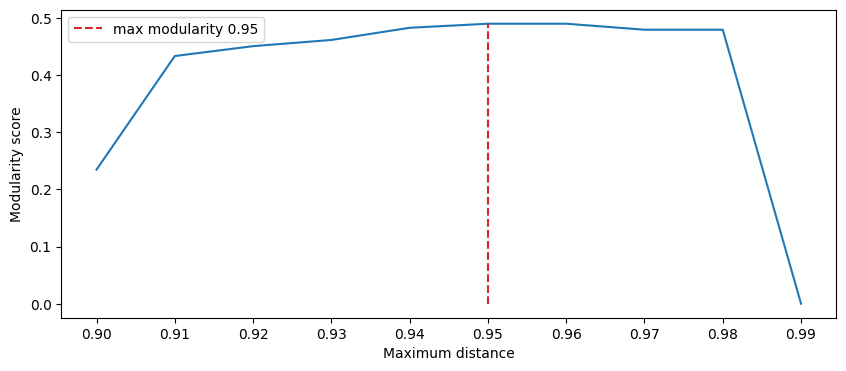

In [104]:
distance = simrank_distance(G)
x_grid = np.linspace(0.9, 0.99, 10)
labels = np.array([agglomerative_clustering(distance, max_dist) for max_dist in x_grid])
modularity_grid(G, labels, x_grid, 'Maximum distance')

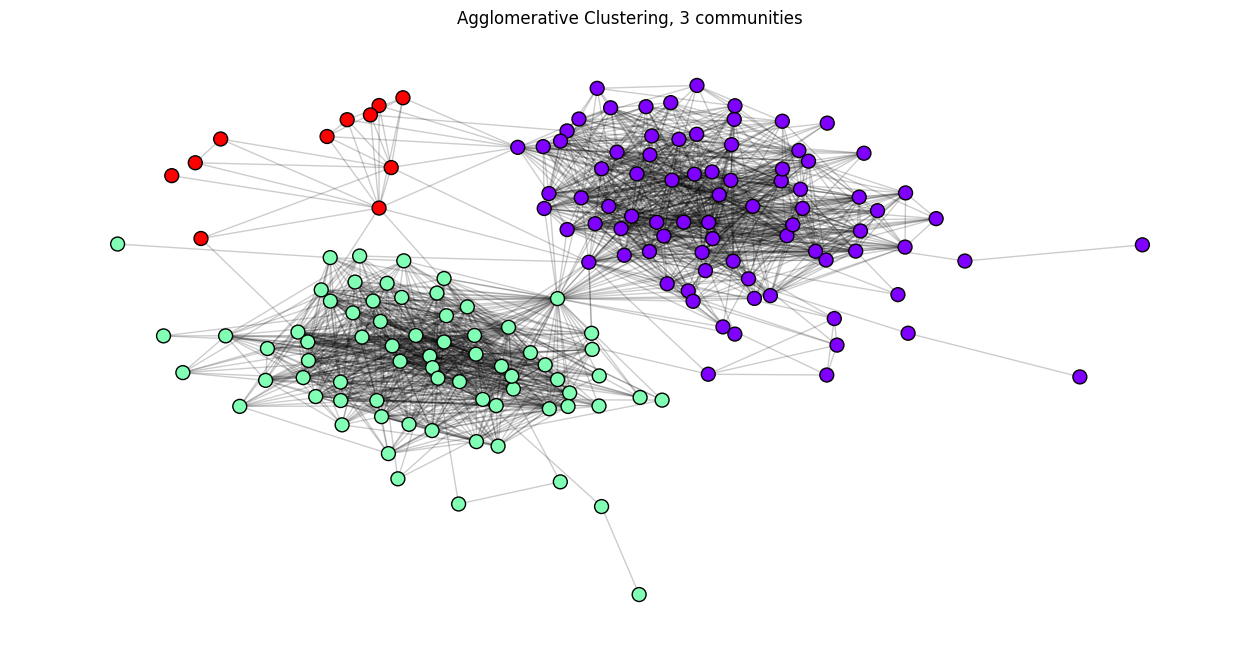

In [105]:
distance = simrank_distance(G)
labels = agglomerative_clustering(distance, max_distance=0.95)

plot_communities(G, labels, 'Agglomerative Clustering')

### Girvan-Newman algorithm

In [106]:
def girvan_newman(G, n):
    labels = np.zeros((n, len(G)))
    _G = G.copy()
    for division in range(n):
        remove_bridges(_G)
        for i, cc in enumerate(nx.connected_components(_G)):
            labels[division, list(cc)] = i
    return labels

def remove_bridges(G):
    num_comp = len(list(nx.connected_components(G)))
    while len(list(nx.connected_components(G))) == num_comp:
        b = nx.edge_betweenness_centrality(G)
        edge = max(b, key=b.get)
        G.remove_edge(*edge)

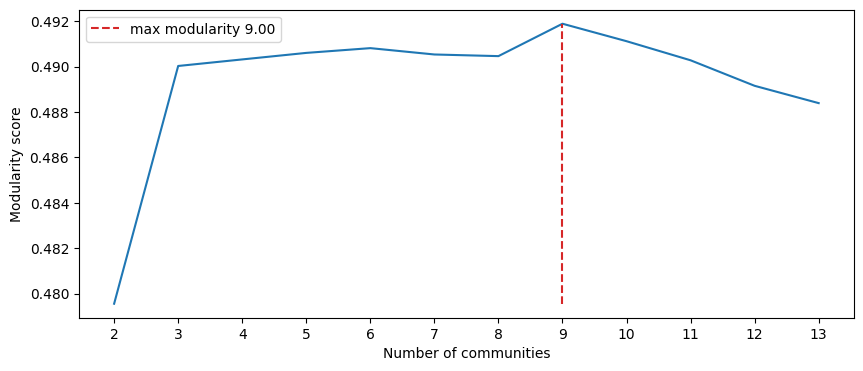

In [107]:
n_iterations = 12
x_grid = np.arange(n_iterations)+2
labels = girvan_newman(G, n_iterations)
modularity_grid(G, labels, x_grid, 'Number of communities')

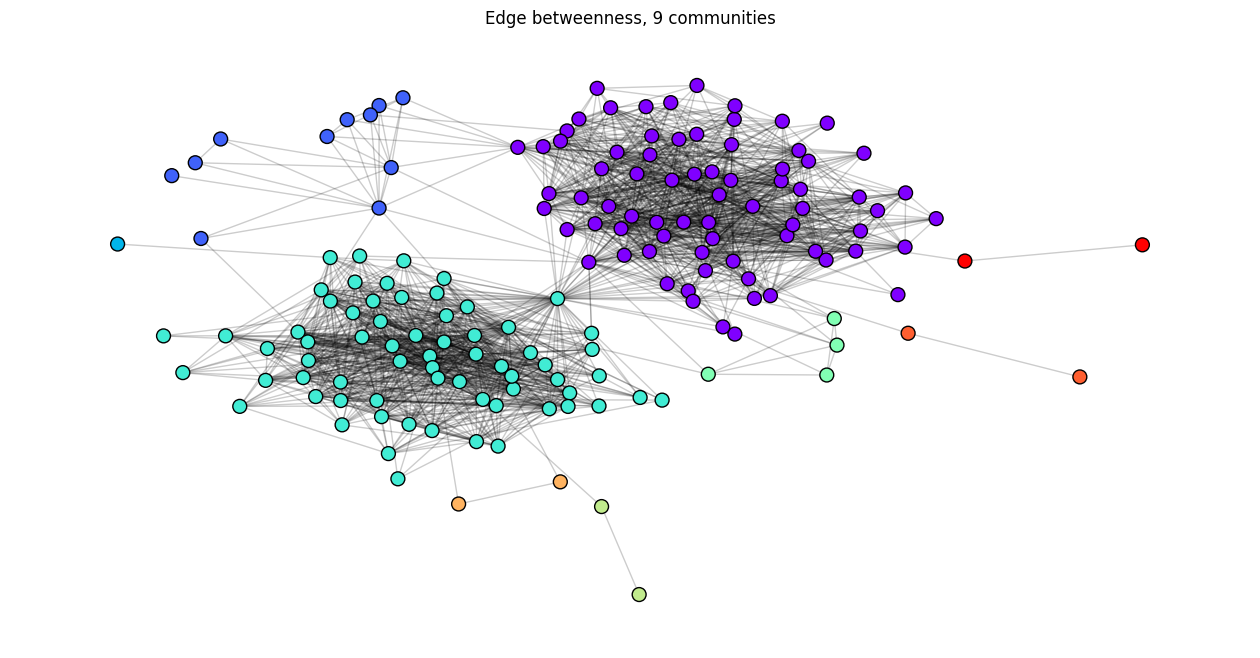

In [108]:
plot_communities(G, labels[9-2], 'Edge betweenness')

### k-cores decomposition

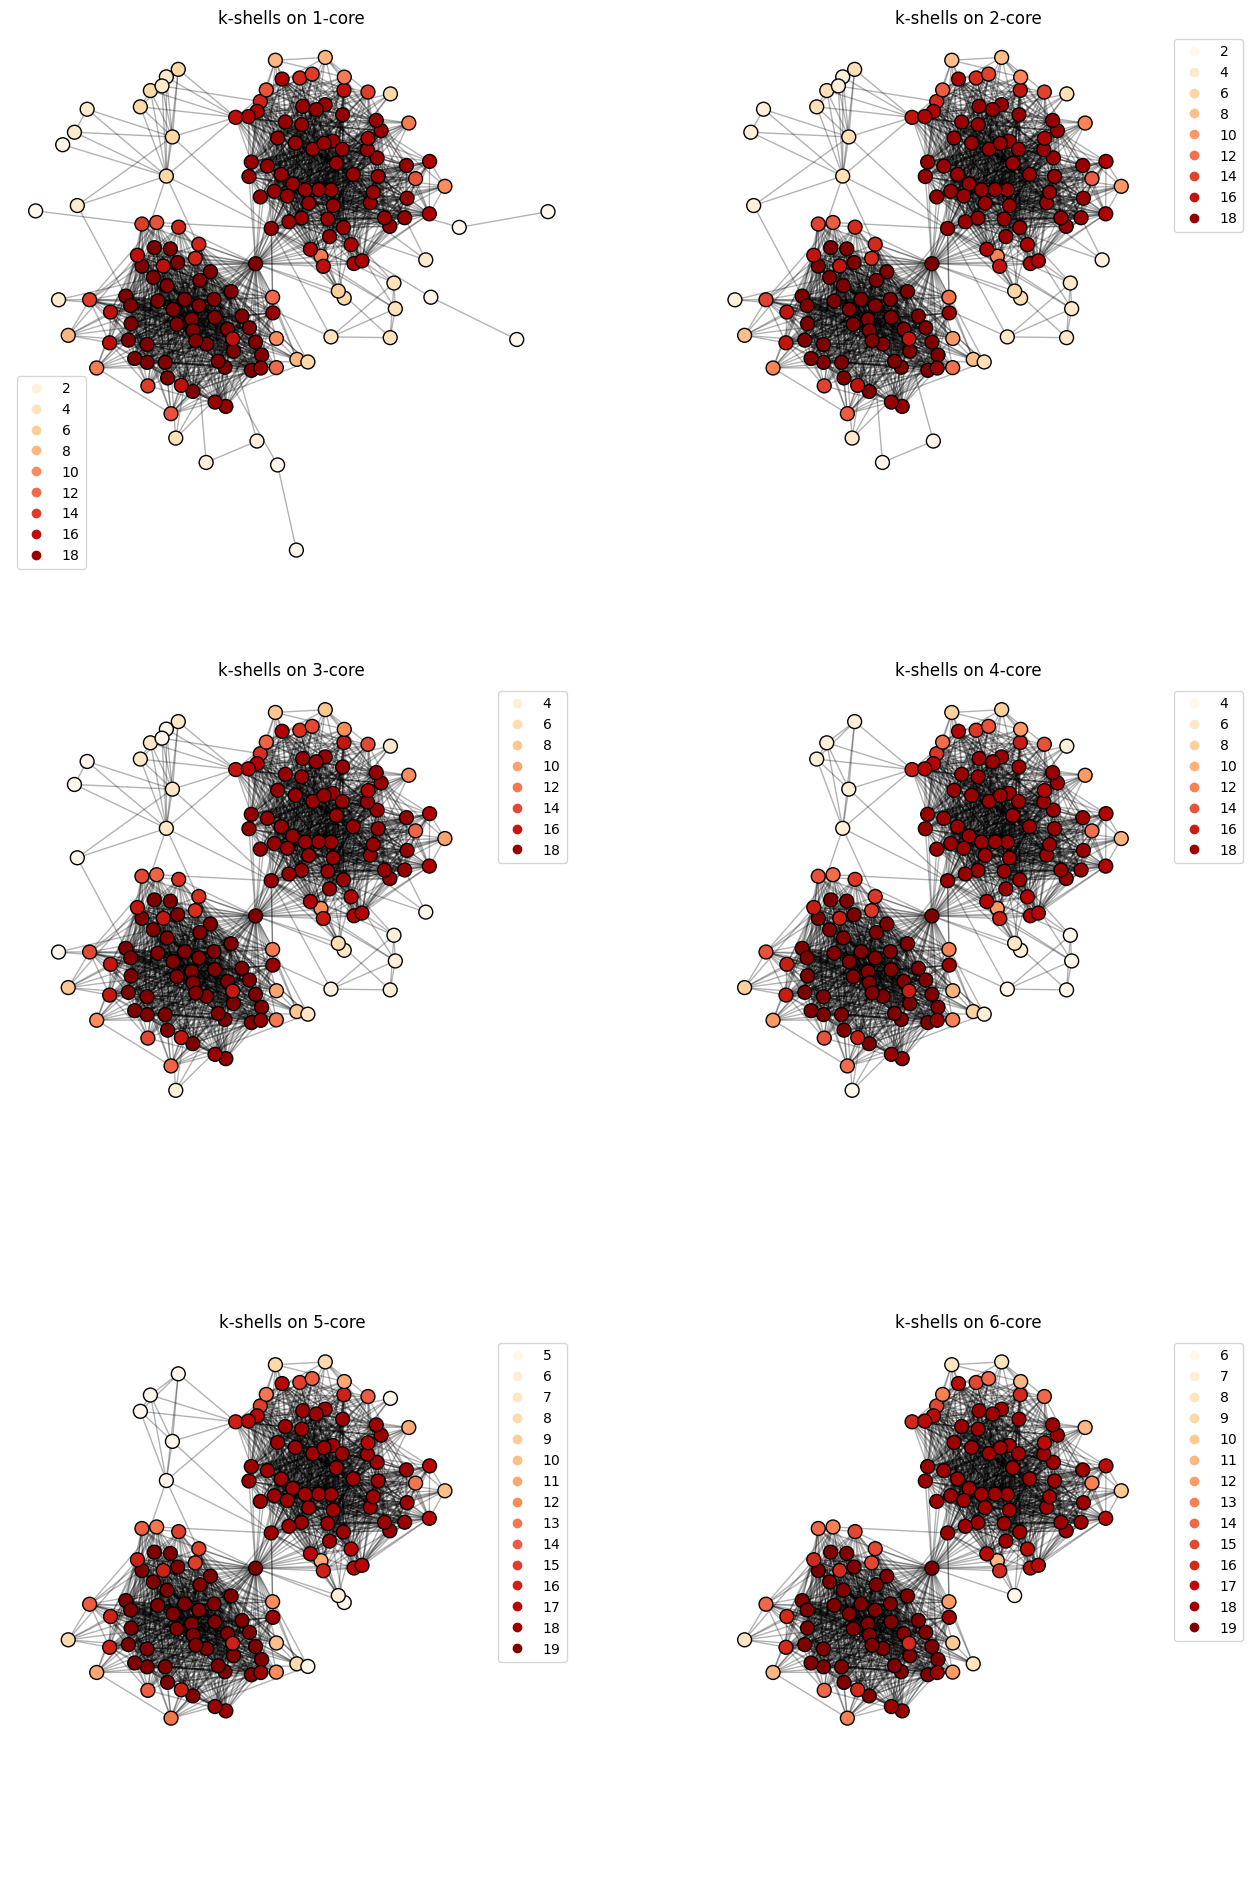

In [109]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

def plot_k_cores(G, num_cores):
    labels = k_core_decompose(G)
    pos = nx.kamada_kawai_layout(G)
    
    rows = int(np.ceil(num_cores / 2))
    plt.figure(figsize=(8*2, 8*rows))

    x_max, y_max = np.array(list(pos.values())).max(axis=0)
    x_min, y_min = np.array(list(pos.values())).min(axis=0)

    for i in range(num_cores):
        plt.subplot(rows, 2, i+1)
        subG = nx.k_core(G, i+1)
        nodes = nx.draw_networkx_nodes(
            subG, 
            pos,
            cmap=plt.cm.OrRd,
            node_color=k_core_decompose(subG), 
            node_size=100, 
            edgecolors='black'
        )
        nx.draw_networkx_edges(
            subG, 
            pos,
            alpha=0.3,
            width=1, 
            edge_color='black'
        )
        eps = (x_max - x_min) * 0.05
        plt.xlim(x_min-eps, x_max+eps)
        plt.ylim(y_min-eps, y_max+eps)
        plt.legend(*nodes.legend_elements())
        plt.axis('off')
        plt.title('k-shells on {}-core'.format(i+1))
        
plot_k_cores(G, 6)

### Clique search

In [110]:
def largest_cliques(G):
    cliques = list(nx.find_cliques(G))
    size_large_clique = max(len(elem) for elem in cliques)
    large_cliques = [elem for elem in cliques if len(elem) == size_large_clique]
    
    red_color = 'tab:red'
    blue_color = 'tab:blue'
    
    dfs, colors, width = [], [], []
    
    for i, clique in enumerate(large_cliques):
        colors.append([red_color if node in clique else blue_color
                       for node in G.nodes()])
        
        width.append([0.5 if (u in clique) and (v in clique) else 0.1
                       for u, v in G.edges()])
        
        dfs.append(pd.DataFrame({
            'index': list(range(len(clique))),
            'name': [G.nodes()[node]['name'] for node in clique]
        }))
    
    return dfs, np.array(colors), np.array(width)

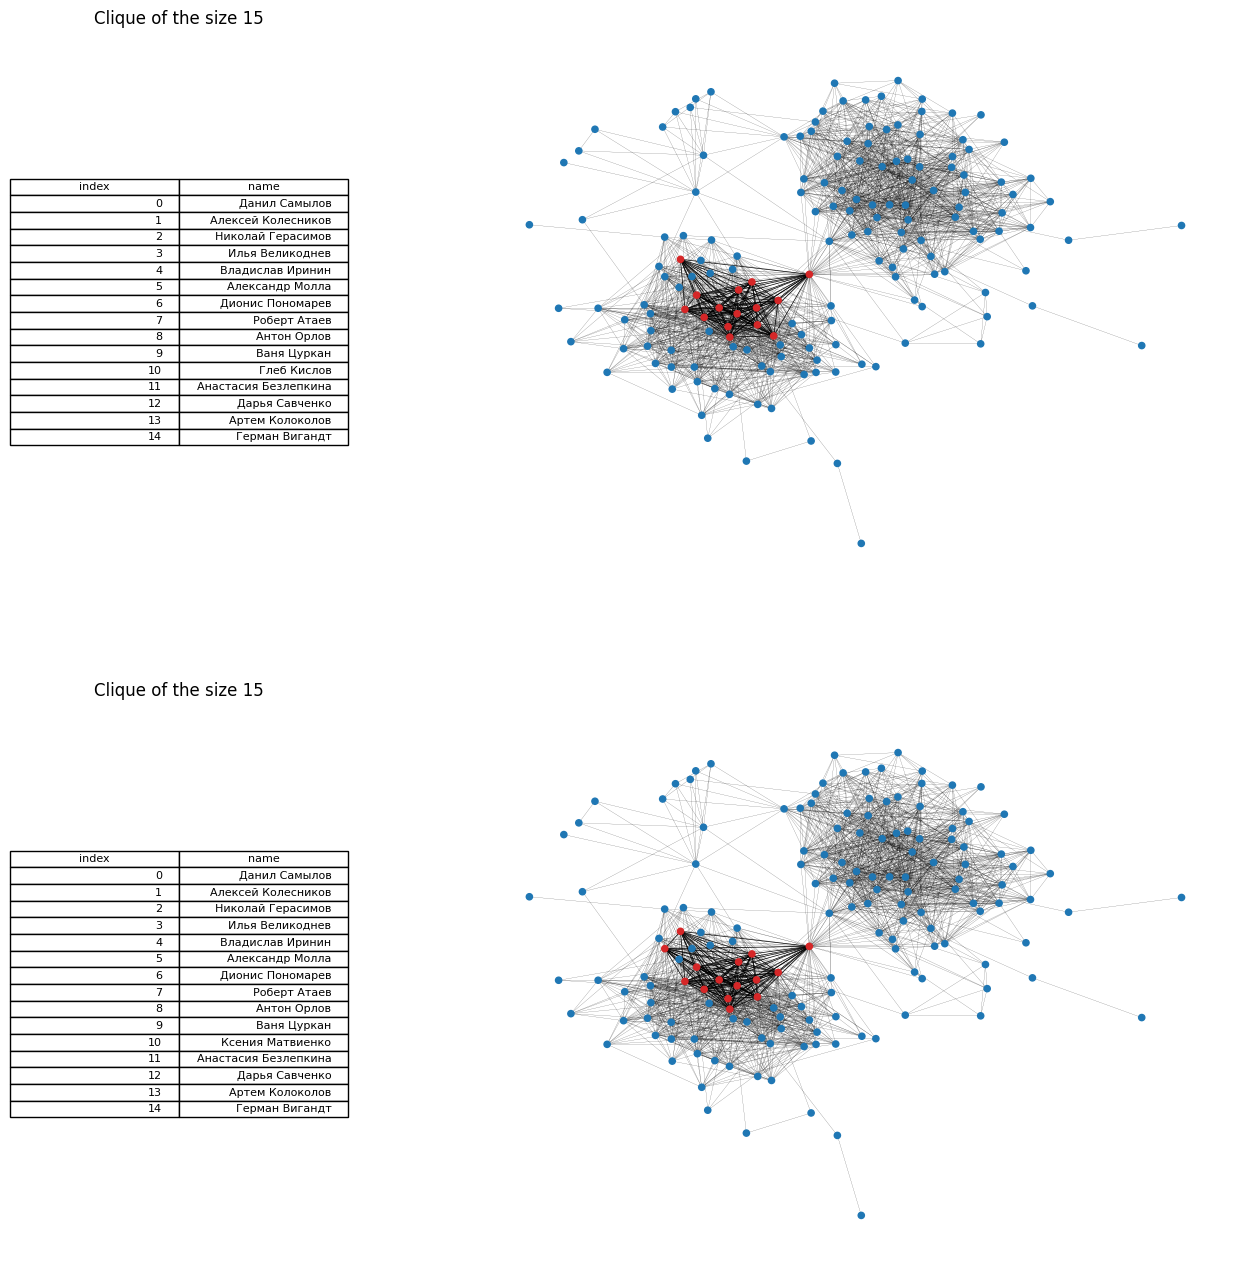

In [111]:
dfs, colors, widths = largest_cliques(G)
number_cliques = colors.shape[0]
size_cliques = np.unique(colors[0], axis=0, return_counts=True)[1][1]

fig, axes = plt.subplots(nrows=len(dfs), ncols=2,
                         figsize=(8*2, 8*len(dfs)),
                         width_ratios=[0.3, 0.7])
layout = nx.kamada_kawai_layout(G)

for i in range(len(axes)):
    cell_text = []
    for row in range(len(dfs[i])):
        cell_text.append(dfs[i].iloc[row])
    axes[i][0].table(cellText=cell_text, colLabels=dfs[i].columns, loc='center')
    
    nx.draw_networkx(G,
                     pos=layout,
                     node_size=20,
                     node_color=colors[i],
                     width=widths[i],
                     with_labels=False,
                     ax=axes[i][1]
                    )
    axes[i][0].axis('off')
    axes[i][1].axis('off')

    axes[i][0].set_title('Clique of the size {}'.format(size_cliques))

plt.show()

In [112]:
n_iterations = 12
labels = girvan_newman(G, n_iterations)
labels = labels[9-2]
nodes = np.arange(G.number_of_nodes())
commun = [list(nodes[labels == i]) for i in range(int(max(labels)) + 1)]

In [114]:
tiu_commun = commun[0]
family_commun = commun[1]
school_commun = commun[3]

In [115]:
import matplotlib.colors as mcolors

In [116]:
base_colors = list(mcolors.TABLEAU_COLORS.keys())

colors = [base_colors[0] for node in nodes]
widths = [0.1 for edge in G.edges()]
dfs = []

for i, com in enumerate([tiu_commun, family_commun, school_commun], 1):
    subG = G.subgraph(com)
    cliques = list(nx.find_cliques(subG))
    size_large_clique = max(len(elem) for elem in cliques)
    large_cliques = [elem for elem in cliques if len(elem) == size_large_clique]
    print(f"{len(large_cliques)} cliques with size {size_large_clique}")
    large_clique = large_cliques[0]
    
    for node in large_clique:
        colors[node] = base_colors[i]
    
    for i, (u, v) in enumerate(G.edges()):
        if u in large_clique and v in large_clique:
            widths[i] = 0.5
    
    dfs.append(pd.DataFrame({'name': [G.nodes()[node]['name'] for node in large_clique]}))

14 cliques with size 12
1 cliques with size 5
2 cliques with size 15


In [117]:
pd.concat([dfs[0], dfs[1], dfs[2]], axis=1).replace({np.nan: ''})

name              name                  name
0            Egor Igorevich  Вячеслав Поляков    Алексей Колесников
1             Султан Абитов   Регина Полякова     Николай Герасимов
2          Артём Венгерский   Валентина Шитая      Владислав Иринин
3             Никита Гончар       Ксюша Шитая       Александр Молла
4              Яна Гуськова       Павел Шитый       Илья Великоднев
5          Анжелика Егорова                            Роберт Атаев
6   Екатерина Красильникова                        Дионис Пономарев
7          Никита Зрайченко                             Антон Орлов
8           Дмитрий Уренков                           Данил Самылов
9             Jacob Zakaria                             Ваня Цуркан
10             Кирилл Орлов                             Глеб Кислов
11            Аршавир Овеян                    Анастасия Безлепкина
12                                                   Дарья Савченко
13                                                  Артем Колоколов
14                                                   Герман Вигандт

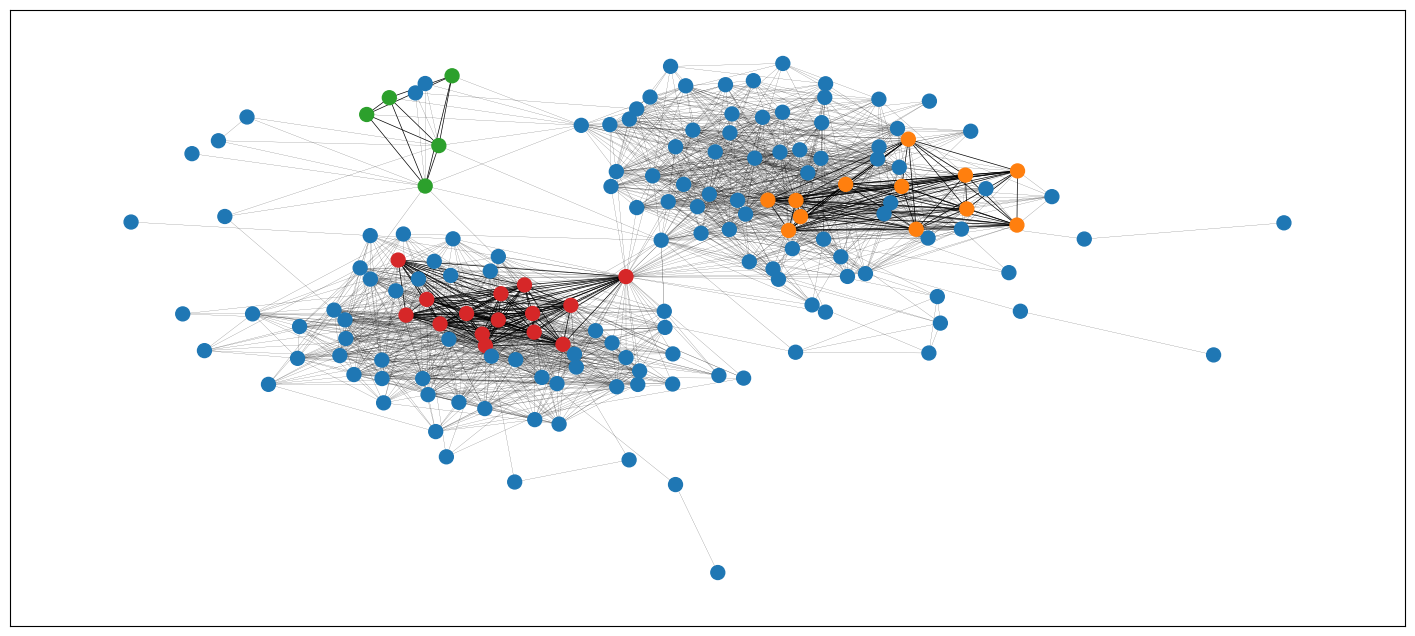

In [118]:
plt.figure(figsize=(18, 8))
layout = nx.kamada_kawai_layout(G)
nx.draw_networkx(G,
                 pos=layout,
                 node_size=100,
                 node_color=colors,
                 width=widths,
                 with_labels=False,
                )